<a href="https://colab.research.google.com/github/Mukiti-Ryan/Customer-Churn-Prediction/blob/main/EDA_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn Prediction with Bank Data**
---
This is a tutorial of a customer churn machine learning model created using the following:

1. GradientBoosting (XG-Boost)
2. Streamlit
3. Docker

In this section we will be carrying out Exploratory Data Analysis in Colab on the dataset to find the relationship between the variables, specifically the relationship between the target variable(STATUS2) which is our customer churn value and all other variables(Binary Categorical Features, Multiple Categorical Features and Continuous Features)

# 1. Let's start by importing the required libraries and loading the dataset into memory
---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/churnmodel.csv')

df.shape

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1000000, 16)

*Initial Data Preparation*

In [ ]:
df.head()

,Unnamed: 0,CD_ACCOUNT,STATUS2,DAYS_ACC_OPEN,CD_TYPE,VL_CREDIT_RECENCY,VL_DEBIT_RECENCY,VL_TENOR,AVGCREDITTURNOVER_LY,AVGDEBITTURNOVER_LY,AVGCREDIT_TRANS_LY,AVGDEBIT_TRANS_LY,AVGCREDITTURNOVER_LY2,AVGDEBITTURNOVER_LY2,AVGCREDIT_TRANS_LY2,AVGDEBIT_TRANS_LY2
0,0,1100000000000.0,NOT CHURNED,6173,1062,21.0,0.0,6170.0,438197.26,-474788.26,3.08,93.66,720779.28,-748023.72,6.33,133.41
1,1,1100000000000.0,CHURNED,6163,1062,313.0,0.0,6118.0,1666.66,-6590.41,0.16,1.25,1666.66,-9322.83,0.16,3.08
2,2,1100000000000.0,CHURNED,6152,1062,2126.0,1949.0,6132.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3,1100000000000.0,CHURNED,6124,1062,982.0,0.0,5770.0,0.00,-1220.00,0.00,0.41,0.00,-2102.00,0.00,0.91
4,4,1100000000000.0,NOT CHURNED,6117,1062,0.0,0.0,6091.0,4126.41,-200.50,1.08,3.66,7935.41,-395.00,2.08,7.50


*Let's eliminate the first column since it's unnamed and also the CD_ACCOUNT since they do not add any value to the dataset*

In [ ]:
if 'Unnamed: 0' in df.columns:
  df = df.drop(columns = ['Unnamed: 0'])

df.drop(['CD_ACCOUNT'], axis = 1, inplace = True)

In [ ]:
print(df.dtypes)

STATUS2                   object
DAYS_ACC_OPEN              int64
CD_TYPE                    int64
VL_CREDIT_RECENCY        float64
VL_DEBIT_RECENCY         float64
VL_TENOR                 float64
AVGCREDITTURNOVER_LY     float64
AVGDEBITTURNOVER_LY      float64
AVGCREDIT_TRANS_LY       float64
AVGDEBIT_TRANS_LY        float64
AVGCREDITTURNOVER_LY2    float64
AVGDEBITTURNOVER_LY2     float64
AVGCREDIT_TRANS_LY2      float64
AVGDEBIT_TRANS_LY2       float64
dtype: object


*Let's convert the STATUS2 column from object to interger*

In [ ]:
df['STATUS2'] = df['STATUS2'].map({'CHURNED': 1, 'NOT CHURNED': 0})
df['STATUS2'].value_counts()

0    500000
1    500000
Name: STATUS2, dtype: int64

In [ ]:
df['CD_TYPE'] = df['CD_TYPE'].map({1062: 1, 1063: 0})
df['CD_TYPE'].value_counts()

1    933953
0     66047
Name: CD_TYPE, dtype: int64

*Let's check for null values*

In [ ]:
df.isnull().sum()

STATUS2                  0
DAYS_ACC_OPEN            0
CD_TYPE                  0
VL_CREDIT_RECENCY        0
VL_DEBIT_RECENCY         0
VL_TENOR                 0
AVGCREDITTURNOVER_LY     0
AVGDEBITTURNOVER_LY      0
AVGCREDIT_TRANS_LY       0
AVGDEBIT_TRANS_LY        0
AVGCREDITTURNOVER_LY2    0
AVGDEBITTURNOVER_LY2     0
AVGCREDIT_TRANS_LY2      0
AVGDEBIT_TRANS_LY2       0
dtype: int64

*Let's check for negative values*

In [ ]:
neg_counts = (df.select_dtypes(include = np.number) < 0).sum()

if neg_counts.any():
  print("Columns with negative values: ")
  print(neg_counts[neg_counts != 0])

  print(f"Total number of negative values: {neg_counts.sum()}")
else:
  print("There are no negative values in the dataset")

Columns with negative values: 
VL_CREDIT_RECENCY          1136
VL_DEBIT_RECENCY             98
VL_TENOR                  10212
AVGCREDITTURNOVER_LY         22
AVGDEBITTURNOVER_LY      746136
AVGCREDIT_TRANS_LY            6
AVGCREDITTURNOVER_LY2        17
AVGDEBITTURNOVER_LY2     792223
AVGCREDIT_TRANS_LY2           5
dtype: int64
Total number of negative values: 1549855


In this case we have several columns with negative values. For example, we have negative debit values which means that certain accounts are in deficit and they owe the bank money. A negative credit on the the other hand indicates that the an account owner deposited money and the bank used it for other purposes hence the bank owes the account owner money. I will leave the negative credit and debit values.

The tenor value is calculated automatically by subtracting today's date from the date the account was created. This means that the tenor values should not be negative hence I will convert them into their absolute values.

In [ ]:
df['VL_TENOR'] = df['VL_TENOR'].abs()

In [ ]:
df.describe()

,STATUS2,DAYS_ACC_OPEN,CD_TYPE,VL_CREDIT_RECENCY,VL_DEBIT_RECENCY,VL_TENOR,AVGCREDITTURNOVER_LY,AVGDEBITTURNOVER_LY,AVGCREDIT_TRANS_LY,AVGDEBIT_TRANS_LY,AVGCREDITTURNOVER_LY2,AVGDEBITTURNOVER_LY2,AVGCREDIT_TRANS_LY2,AVGDEBIT_TRANS_LY2
count,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000
mean,0.5,2284.078102,0.933953,1253.543128,1979.869018,2382.946083,6.199422e+04,-6.279789e+04,2.469594,4.593288,2.075194e+05,-2.086299e+05,4.622181,8.833637
std,0.5,1737.424068,0.248364,4144.026051,5478.787665,2439.527684,8.613043e+06,8.593854e+06,49.061543,17.684722,9.422977e+07,9.423014e+07,90.504225,29.221068
min,0.0,20.000000,0.000000,-300.000000,-81.000000,0.000000,-2.564250e+04,-6.375980e+09,-0.080000,0.000000,-2.564250e+04,-9.306696e+10,-0.080000,0.000000
25%,0.0,762.000000,1.000000,0.000000,0.000000,721.000000,0.000000e+00,-1.022263e+04,0.000000,0.080000,2.080000e+00,-2.114132e+04,0.080000,0.250000
50%,0.5,1972.000000,1.000000,26.000000,0.000000,1862.000000,2.416600e+02,-1.625000e+02,0.330000,0.580000,1.531630e+03,-1.333330e+03,0.580000,1.160000
75%,1.0,3461.000000,1.000000,392.000000,378.000000,3456.000000,9.986130e+03,0.000000e+00,0.910000,3.910000,2.098290e+04,-3.100000e-01,1.660000,7.410000
max,1.0,44655.000000,1.000000,19406.000000,19407.000000,44653.000000,6.375964e+09,1.563590e+03,25433.250000,12109.330000,9.306696e+10,1.563590e+03,47800.660000,15476.660000


In [ ]:
df.head().T

,0,1,2,3,4
STATUS2,0.00,1.00,1.0,1.00,0.00
DAYS_ACC_OPEN,6173.00,6163.00,6152.0,6124.00,6117.00
CD_TYPE,1.00,1.00,1.0,1.00,1.00
VL_CREDIT_RECENCY,21.00,313.00,2126.0,982.00,0.00
VL_DEBIT_RECENCY,0.00,0.00,1949.0,0.00,0.00
VL_TENOR,6170.00,6118.00,6132.0,5770.00,6091.00
AVGCREDITTURNOVER_LY,438197.26,1666.66,0.0,0.00,4126.41
AVGDEBITTURNOVER_LY,-474788.26,-6590.41,0.0,-1220.00,-200.50
AVGCREDIT_TRANS_LY,3.08,0.16,0.0,0.00,1.08
AVGDEBIT_TRANS_LY,93.66,1.25,0.0,0.41,3.66


Let's modify the column names and string values in the DataFrame to a standardized format, making it easier to work with and analyze the data. This is done to ensure consistency in the formatting of string values across columns, which can be helpful for analysis and modeling.

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
  df[col] = df[col].str.lower().str.replace(' ', '_')

In [ ]:
df.head().T

,0,1,2,3,4
status2,0.00,1.00,1.0,1.00,0.00
days_acc_open,6173.00,6163.00,6152.0,6124.00,6117.00
cd_type,1.00,1.00,1.0,1.00,1.00
vl_credit_recency,21.00,313.00,2126.0,982.00,0.00
vl_debit_recency,0.00,0.00,1949.0,0.00,0.00
vl_tenor,6170.00,6118.00,6132.0,5770.00,6091.00
avgcreditturnover_ly,438197.26,1666.66,0.0,0.00,4126.41
avgdebitturnover_ly,-474788.26,-6590.41,0.0,-1220.00,-200.50
avgcredit_trans_ly,3.08,0.16,0.0,0.00,1.08
avgdebit_trans_ly,93.66,1.25,0.0,0.41,3.66


# 2. Exploratory Data Analysis (EDA)
---
Let's establish the relationship between the target variable(STATUS2) and all the other variables

<AxesSubplot:xlabel='status2', ylabel='count'>

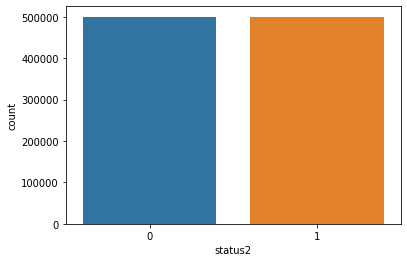

In [ ]:
sns.countplot(x = 'status2', data = df)

The above visualization indicates that there is no imbalance in the target variable hence here in no need to upsample or downsample.

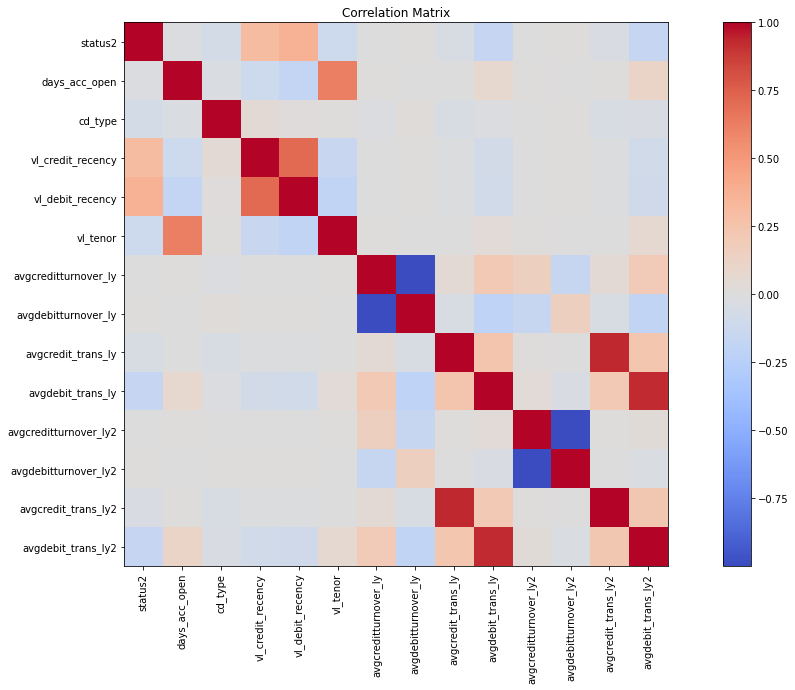

In [ ]:
corr = df.corr()

plt.figure(figsize = (20, 10))
plt.imshow(corr, cmap = 'coolwarm', interpolation = 'none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation = 90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

Let's differentiate between the categorical variables and numerical variables. Categorical variables are normally objects in nature, but in our case we have only one variable which is an integer in nature.

In [ ]:
binary = ['cd_type']
numerical = ['days_acc_open', 'vl_credit_recency', 'vl_debit_recency', 'vl_tenor', 'avgcreditturnover_ly', 'avgdebitturnover_ly', 'avgcredit_trans_ly', 
             'avgdebit_trans_ly', 'avgcreditturnover_ly2', 'avgdebitturnover_ly2', 'avgcredit_trans_ly2', 'avgdebit_trans_ly2']

1. Categorical Variables
---


In [ ]:
df[binary].nunique()

cd_type    2
dtype: int64

<AxesSubplot:xlabel='cd_type', ylabel='count'>

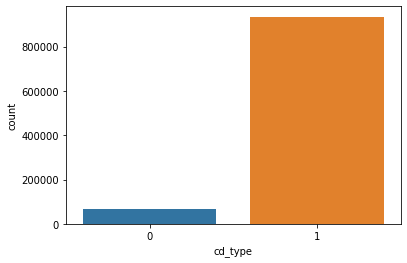

In [ ]:
sns.countplot(x = "cd_type", data = df)

Account type 1062 is the most famous account type amongst the customers.

2. Numerical features
---

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

<AxesSubplot:xlabel='avgdebit_trans_ly2', ylabel='Density'>

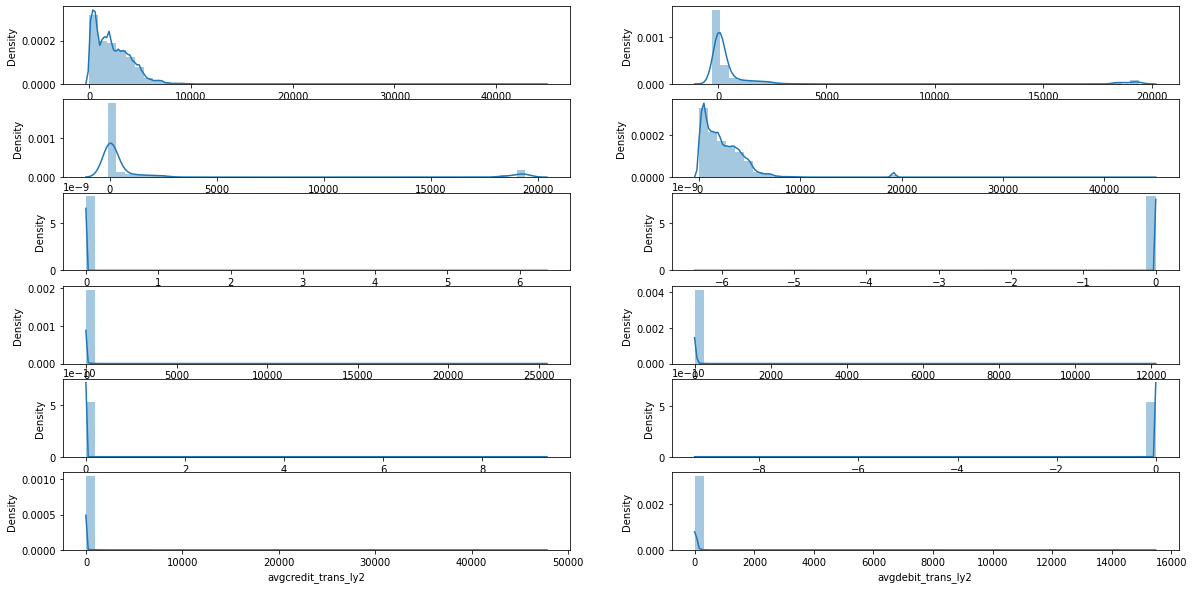

In [ ]:
fig, axes = plt.subplots(6, 2, figsize = (20, 10))

sns.distplot(df["days_acc_open"], ax = axes[0, 0])
sns.distplot(df["vl_credit_recency"], ax = axes[0, 1])
sns.distplot(df["vl_debit_recency"], ax = axes[1, 0])
sns.distplot(df["vl_tenor"], ax = axes[1, 1])
sns.distplot(df["avgcreditturnover_ly"], ax = axes[2, 0])
sns.distplot(df["avgdebitturnover_ly"], ax = axes[2, 1])
sns.distplot(df["avgcredit_trans_ly"], ax = axes[3, 0])
sns.distplot(df["avgdebit_trans_ly"], ax = axes[3, 1])
sns.distplot(df["avgcreditturnover_ly2"], ax = axes[4, 0])
sns.distplot(df["avgdebitturnover_ly2"], ax = axes[4, 1])
sns.distplot(df["avgcredit_trans_ly2"], ax = axes[5, 0])
sns.distplot(df["avgdebit_trans_ly2"], ax = axes[5, 1])

In [ ]:
display(df[['days_acc_open', 'status2']].groupby('status2').mean(),
        df[['vl_credit_recency', 'status2']].groupby('status2').mean(),
        df[['vl_debit_recency', 'status2']].groupby('status2').mean(),
        df[['vl_tenor', 'status2']].groupby('status2').mean(),
        df[['avgcreditturnover_ly', 'status2']].groupby('status2').mean(),
        df[['avgdebitturnover_ly', 'status2']].groupby('status2').mean(),
        df[['avgcredit_trans_ly', 'status2']].groupby('status2').mean(),
        df[['avgdebit_trans_ly', 'status2']].groupby('status2').mean(),
        df[['avgcreditturnover_ly2', 'status2']].groupby('status2').mean(),
        df[['avgdebitturnover_ly2', 'status2']].groupby('status2').mean(),
        df[['avgcredit_trans_ly2', 'status2']].groupby('status2').mean(),
        df[['avgdebit_trans_ly2', 'status2']].groupby('status2').mean())

,days_acc_open
status2,
0,2312.822070
1,2255.334134


,vl_credit_recency
status2,
0,9.306168
1,2497.780088


,vl_debit_recency
status2,
0,3.683280
1,3956.054756


,vl_tenor
status2,
0,2657.664280
1,2108.227886


,avgcreditturnover_ly
status2,
0,113402.352946
1,10586.085553


,avgdebitturnover_ly
status2,
0,-114379.669191
1,-11216.102554


,avgcredit_trans_ly
status2,
0,4.440382
1,0.498807


,avgdebit_trans_ly
status2,
0,7.499620
1,1.686956


,avgcreditturnover_ly2
status2,
0,389808.289739
1,25230.477233


,avgdebitturnover_ly2
status2,
0,-390810.959032
1,-26448.887029


,avgcredit_trans_ly2
status2,
0,7.851147
1,1.393215


,avgdebit_trans_ly2
status2,
0,13.844847
1,3.822426


In [ ]:
df[numerical].nunique()

days_acc_open              8054
vl_credit_recency          4914
vl_debit_recency           4927
vl_tenor                  10077
avgcreditturnover_ly     330374
avgdebitturnover_ly      388473
avgcredit_trans_ly         3740
avgdebit_trans_ly          2356
avgcreditturnover_ly2    408691
avgdebitturnover_ly2     463830
avgcredit_trans_ly2        5023
avgdebit_trans_ly2         3790
dtype: int64

# 3. Feature Importance
---

In [ ]:
global_mean = df.status2.mean()
round(global_mean, 3)

0.5

The code below is useful for identifying patterns or differences in churn rates between different groups within each categorical variable, and for assessing the relative risk of each group. 

This analysis can be useful for understanding the factors that drive churn, and for developing targeted strategies to reduce churn for specific groups.

In [ ]:
for col in binary:
    df_group = df.groupby(by=col).status2.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
cd_type,,,
0,0.623707,0.123707,1.247415
1,0.491252,-0.008748,0.982503


In [ ]:
df[numerical].corrwith(df.status2).to_frame('correlation')

,correlation
days_acc_open,-0.016544
vl_credit_recency,0.300248
vl_debit_recency,0.360698
vl_tenor,-0.112611
avgcreditturnover_ly,-0.005969
avgdebitturnover_ly,0.006002
avgcredit_trans_ly,-0.040170
avgdebit_trans_ly,-0.164341
avgcreditturnover_ly2,-0.001935
avgdebitturnover_ly2,0.001933


In [ ]:
df.groupby(by = 'status2')[numerical].mean()

,days_acc_open,vl_credit_recency,vl_debit_recency,vl_tenor,avgcreditturnover_ly,avgdebitturnover_ly,avgcredit_trans_ly,avgdebit_trans_ly,avgcreditturnover_ly2,avgdebitturnover_ly2,avgcredit_trans_ly2,avgdebit_trans_ly2
status2,,,,,,,,,,,,
0,2312.822070,9.306168,3.683280,2657.664280,113402.352946,-114379.669191,4.440382,7.499620,389808.289739,-390810.959032,7.851147,13.844847
1,2255.334134,2497.780088,3956.054756,2108.227886,10586.085553,-11216.102554,0.498807,1.686956,25230.477233,-26448.887029,1.393215,3.822426


Since all our variables are numerical, thee will be no need to perform encoding on the data.

*Let's train GradientBoost:*

In [ ]:
X = df.drop('status2', axis = 1)
y = df['status2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 3)

gb_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
y_pred = gb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0
